# This notebook presents the computation of ground state energy of the transverse Ising model using Variational Quantum Eigensolver (VQE) provided by qiskit.Aqua. This example is inspired by the article arXiv:1804.03719.

## In this example, I will compute the ground state energy and magnetization of the Ising model using VQE with two trial wave functions- product state, entangled state. The intermediate optimization steps will be shown. I will also compute direct diagonalization of the Hamiltonian and compare the results of these three computations.  
## For running VQE, we need to assign input Hamiltonian, initial wave function, optimizer. In the following, you shall see how to use VQE. Let's get our hands dirty with qiskit.

In [1]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.tools.visualization import plot_histogram
from qiskit import BasicAer
from qiskit.aqua import Operator, run_algorithm, QuantumInstance, aqua_globals
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.components.variational_forms import RY, RYRZ
from qiskit.aqua.components.optimizers import L_BFGS_B, COBYLA, AQGD, NELDER_MEAD
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.algorithms import VQE
from qiskit.quantum_info import Pauli
from matplotlib import pyplot as plt
import os
import numpy as np

The input of VQE includes: initial wave function, depth, EnergyInput.
The initial wave function is the variational form constructed from a quantum circuit and computed by the RY class.
Depth is the number of rotation gates when preparing the initial wave function in RY (qiskit-aqua/ry.py).
EnergyInput is the Hamiltonian of the system. Below shows an example of constructing the initial wave function by calling RY. 


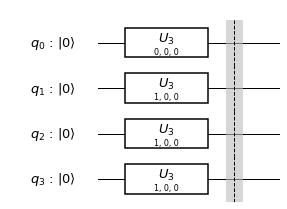

In [2]:
# an example of preparing the initial state for variational method
init_state = Zero(4)
var_form = RY(4, 0, initial_state=init_state)
cir=var_form.construct_circuit([0,1,1,1])
cir.draw(output='mpl')

### The following I define the Hatmiltonian and the utility functions. The Hamiltonian is a one dimensional transverse Ising model with periodic boundary condition.
$H=g\sum_{\langle i,j\rangle}  \sigma_z^i\sigma_z^j-h\sum_i\sigma^i_x$, 
where $i, j$ are the site index ,  $< >$ denotes the nearser neighbor. 

In [3]:
# construct Ising model as EnergyInput for VQE
# reference: 1804.03719 sect. XVII

def contruct_hamiltonian_dict(g=-1, h=1):
     # g the neighboring coupling constant
    # h the magnetization constant
    # one can convert the label to array by Pauli.to_matrix(Pauli.from_label('XI'))
    ising_dict = {
                'paulis': [{"coeff": {"imag": 0.0, "real": g}, "label": "ZZII"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "IZZI"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "IIZZ"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "ZIIZ"}, # when periodic B.C.
                           {"coeff": {"imag": 0.0, "real": -1*h}, "label": "XIII"},
                           {"coeff": {"imag": 0.0, "real": -1*h}, "label": "IXII"},
                           {"coeff": {"imag": 0.0, "real": -1*h}, "label": "IIXI"},
                           {"coeff": {"imag": 0.0, "real": -1*h}, "label": "IIIX"}
                           ]
            }
    return ising_dict

In [4]:
# This is a utility function to help us record the intermediate results
def print_intermediate_state(eval_count, parameters, mean, std):
    fn='intermediate.txt'
    with open(fn, 'a') as f:
        content = "{},{:.5f},{:.5f}".format(eval_count, mean, std)
        print(content, file=f, flush=True)
    #print('count={}, parameters={}, mean={}, std={}'.format(eval_count, parameters, mean, std))

In [20]:
def prepare_vqe(ising_dict, depth):
    backend = BasicAer.get_backend('statevector_simulator')
    optimizer = COBYLA()#L_BFGS_B()
    qubit_op = Operator.load_from_dict(ising_dict)
    algo_input=EnergyInput(qubit_op)
    num_qubits = algo_input.qubit_op.num_qubits
    init_state = Zero(num_qubits)
    var_form = RY(num_qubits, depth, initial_state=init_state) # depth>0, use default entanglement
    fn='intermediate.txt'
    if os.path.isfile(fn):
        os.remove(fn)
    algo = VQE(algo_input.qubit_op, var_form, optimizer, 'paulis', max_evals_grouped=1, callback=print_intermediate_state)
    quantum_instance = QuantumInstance(backend,shots=1024)
    return algo, quantum_instance

In [12]:
# this is to calculate the expectation value of an operator given the ground state eigenvector
def calc_expectation(min_vector,opt):
    right_prod=np.dot(opt, min_vector)
    final=np.dot(np.transpose(min_vector.conjugate()), right_prod)
    return final
    

In [13]:
# this is a utility function for creating 2 by 2 pauli_array
def pauli_array():
    # define Pauli matrices
    sx=np.array([[0,1],[1,0]])
    sy=np.array([[0,-1j],[1j,0]])
    sz=np.array([[1,0],[0,-1]])
    identity=np.array([[1,0],[0,1]])
    return sx, sy, sz, identity

In [14]:
# define Pauli matrices for the four qubit system for the exact diagonalization
sx, sy, sz, identity=pauli_array()


# tensor product 
XI=np.kron(sx,identity)
YI=np.kron(sy, identity)
ZI=np.kron(sz, identity)
IX=np.kron(identity,sx)
IY=np.kron(identity, sy)
IZ=np.kron( identity,sz)
ZZ=np.kron(sz,sz)
II=np.kron(np.identity(2), np.identity(2))
ZZII=np.kron(ZZ,II)
IZZI=np.kron(np.identity(2), np.kron(ZZ,np.identity(2)))
IIZZ=np.kron(II,ZZ)
ZIIZ=np.kron(ZI,IZ) # add this term when periodic B.C.
XIII=np.kron(XI,II)
IXII=np.kron(IX,II)
IIXI=np.kron(II,XI)
IIIX=np.kron(II,IX)
ZIII=np.kron(ZI,II)
IZII=np.kron(IZ,II)
IIZI=np.kron(II,ZI)
IIIZ=np.kron(II,IZ)

### After defining all the functions, we can now run vqe and observe the optimization steps.

In [21]:
# one can try some limiting cases: g=0 and h=1; g=1 and h=0
sx, sy, sz, identity=pauli_array()
mx_chain=XIII+IXII+IIXI+IIIX
#mx_chain_=np.kron(np.kron(sx,sx), np.kron(sx,sx))
mz_chain=ZIII+IZII+IIZI+IIIZ
#mz_chain_=np.kron(np.kron(sz,sz), np.kron(sz,sz))
ising_dict=contruct_hamiltonian_dict(g=-1,h=1)
algo, quantum_instance=prepare_vqe(ising_dict,depth=1)
result=algo.run(quantum_instance)
expect_mx_chain=calc_expectation(result['min_vector'], mx_chain)
expect_mz_chain=calc_expectation(result['min_vector'], mz_chain)


In [22]:
# print out the optimization log
print('==================optimization output========================')
print('The ground state energy is {}'.format(result['energy']))
print('The mean spin along x of the system is {}'.format(expect_mx_chain/4))
print('The mean spin along z of the system is {}'.format(expect_mz_chain/4))
print('Total evaluation count is {}.'.format(result['eval_count']))
print('The amount of time is {} seconds.'.format(result['eval_time']))

==================optimization output========================
The ground state energy is -5.0281388477067726
The mean spin along x of the system is (0.5263706989210727+0j)
The mean spin along z of the system is (-0.8431057227226636+0j)
Total evaluation count is 1000.
The amount of time is 16.564425230026245 seconds.


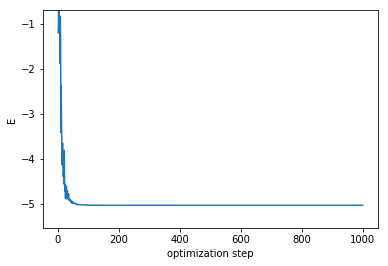

In [23]:
# Plot out the intermediate steps
step=[]
energy=[]
filename='intermediate.txt'
with open(filename,'r') as f:
    steps=f.readlines()  
    for row in steps:
        step.append(float(row.strip().split(',')[0])) 
        energy.append(float(row.strip().split(',')[-2]))
plt.figure()
plt.ylim([energy[-1]-0.5, energy[0]+0.5])
plt.plot(step,energy)
plt.xlabel('optimization step')
plt.ylabel('E')
plt.show()

## Are the VQE's results correct? Let's comare the results with exact diagonalization. In the following, I will vary the value of h and compute the corresponding ground state energy and the magnetization along x.

In [24]:
# compute VQE ground state energy by giving product state and entanglend state, respectively, as trial wave function
q_prod_mine=[]
q_ent_mine=[]
q_ent_mx=[]
q_prod_mx=[]
g=-1
h_array=np.linspace(0,3,16)
for h in h_array:
    ising_dict=contruct_hamiltonian_dict(g=g,h=h)
    algo, quantum_instance=prepare_vqe(ising_dict=ising_dict, depth=0)
    result=algo.run(quantum_instance)
    q_prod_mine.append(result['energy'])
    q_prod_mx.append(calc_expectation(result['min_vector'], mx_chain))
    
    algo, quantum_instance=prepare_vqe(ising_dict=ising_dict, depth=3)
    result=algo.run(quantum_instance)
    q_ent_mine.append(result['energy'])
    q_ent_mx.append(calc_expectation(result['min_vector'], mx_chain))

In [25]:
# do direct diagonalization of the Hamiltonian to get exact ground state energy
mine=[]
mx=[]
for h in h_array:
    H=g*(ZZII+IZZI+IIZZ+ZIIZ)-h*(XIII+IXII+IIXI+IIIX)
    e=min(np.linalg.eigvals(H))
    w,v=np.linalg.eig(H)
    e=min(w)
    idx=np.argmin(w)
    min_vector=v[:,idx]
    mine.append(e)
    mx.append(calc_expectation(min_vector, mx_chain))


/anaconda3/envs/qiskitenv/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


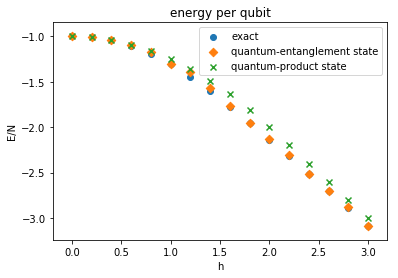

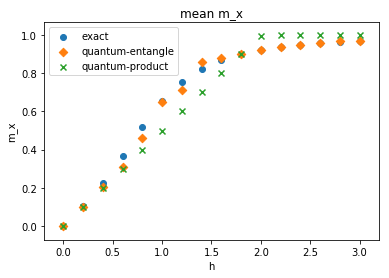

In [26]:
# Finally, let's put all results together
mine_=np.array(mine)/4
q_ent_mine_=np.array(q_ent_mine)/4
q_prod_mine_=np.array(q_prod_mine)/4
plt.figure(1)
plt.title('energy per qubit')
plt.scatter(h_array, mine_, label='exact')
plt.scatter(h_array, q_ent_mine_, label='quantum-entanglement state', marker='D')
plt.scatter(h_array,q_prod_mine_, label='quantum-product state', marker='x')
plt.xlabel('h')
plt.ylabel('E/N')
plt.legend()
plt.figure(2)
plt.title('mean m_x')
plt.scatter(h_array, np.array(mx)/4, label='exact')
plt.scatter(h_array, np.array(q_ent_mx)/4, label='quantum-entangle', marker='D')
plt.scatter(h_array, np.array(q_prod_mx)/4, label='quantum-product', marker='x')
plt.xlabel('h')
plt.ylabel('m_x')
plt.legend()

### For VQE, the choice of initial wave function is essential and relies on the understanding of the problem. In this example, we show that the results of the entanglement state match with the exact solution, while the results of the product state deviate. 

## For the future project, what could be investigated:   
### long range interaction   
### magnetic field (orbital effect)   
### first excited state (gap protection of entangled ground state)   